# Cleaning US Census Data

You just got hired as a Data Analyst at the Census Bureau, which collects census data and creates interesting visualizations and insights from it.

The person who had your job before you left you all the data they had for the most recent census. It is in multiple `csv` files. They didn't use pandas, they would just look through these `csv` files manually whenever they wanted to find something. Sometimes they would copy and paste certain numbers into Excel to make charts.

The thought of it makes you shiver. This is not scalable or repeatable.

Your boss wants you to make some scatterplots and histograms by the end of the day. Can you get this data into `pandas` and into reasonable shape so that you can make these histograms?

## Inspect the Data!

1. The first visualization your boss wants you to make is a scatterplot that shows average income in a state vs proportion of women in that state.

   Open some of the census `csv` files that came with the kit you downloaded. How are they named? What kind of information do they hold? Will they help us make this graph?

**AJC** notes:
- Female population is 'hidden' in the 'GenderPop' column (split on '_') and will need to be extracted using regex, before being used to calculate the female proportion from the 'TotalPop' column.
- There look to be 1 duplicate row (state) per file so these will be dropped
- Scatterplot will be of 'Income' vs 'FemaleProportion' (calculated as above) and we will use the 'State' column as the index.


2. It will be easier to inspect this data once we have it in a DataFrame. You can't even call `.head()` on these `csv`s! How are you supposed to read them?

   Using `glob`, loop through the census files available and load them into DataFrames. Then, concatenate all of those DataFrames together into one DataFrame, called something like `us_census`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
files = glob.glob("states*.csv")
df_list = []
for file in files:
    data = pd.read_csv(file)
    df_list.append(data)

us_census = pd.concat(df_list)

3. Look at the `.columns` and the `.dtypes` of the `us_census` DataFrame. Are those datatypes going to hinder you as you try to make histograms?

In [3]:
print(us_census.columns)
print(us_census.dtypes)

Index(['Unnamed: 0', 'State', 'TotalPop', 'Hispanic', 'White', 'Black',
       'Native', 'Asian', 'Pacific', 'Income', 'GenderPop'],
      dtype='object')
Unnamed: 0     int64
State         object
TotalPop       int64
Hispanic      object
White         object
Black         object
Native        object
Asian         object
Pacific       object
Income        object
GenderPop     object
dtype: object


4. Look at the `head()` of the DataFrame so that you can understand why some of these `dtypes` are objects instead of integers or floats.

   Start to make a plan for how to convert these columns into the right types for manipulation.

In [4]:
us_census.head()

,Unnamed: 0,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop
0,0,Rhode Island,1053661,13.36%,74.33%,5.68%,0.35%,3.25%,0.04%,"$59,125.27",510388M_543273F
1,1,South Carolina,4777576,5.06%,62.89%,28.75%,0.29%,1.25%,0.05%,"$46,296.81",2322409M_2455167F
2,2,South Dakota,843190,3.24%,82.50%,1.42%,9.42%,1.02%,0.04%,"$51,805.41",423477M_419713F
3,3,Tennessee,6499615,4.72%,73.49%,18.28%,0.23%,1.41%,0.04%,"$47,328.08",3167756M_3331859F
4,4,Texas,26538614,38.05%,44.69%,11.65%,0.26%,3.67%,0.07%,"$55,874.52",13171316M_13367298F


**AJC** - The columns we're interested in are:
- 'TotalPop' - this has a dtype of int64 so is fine
- 'Income' - this has a dtype of object so will need to be converted to numeric. First, we will need to remove the '$' and convert to numeric.
- 'GenderPop' - this has a dtype of object so will need to be split on '_' and converted to numeric.

## Regex to the Rescue

5. Use regex to turn the `Income` column into a format that is ready for conversion into a numerical type.

In [7]:
us_census['Income'] = us_census['Income'].replace('[\$,]', '', regex=True)
us_census['Income'] = pd.to_numeric(us_census['Income'])

# check new data type
print(us_census['Income'].dtypes)

float64


6. Look at the `GenderPop` column. We are going to want to separate this into two columns, the `Men` column, and the `Women` column.

   Split the column into those two new columns using `str.split` and separating out those results.

In [8]:
us_census['Men'] = us_census['GenderPop'].str.split('_').str.get(0)
us_census['Women'] = us_census['GenderPop'].str.split('_').str.get(1)

# check new columns
print(us_census.head())

   Unnamed: 0           State  TotalPop Hispanic   White   Black Native  \
0           0    Rhode Island   1053661   13.36%  74.33%   5.68%  0.35%   
1           1  South Carolina   4777576    5.06%  62.89%  28.75%  0.29%   
2           2    South Dakota    843190    3.24%  82.50%   1.42%  9.42%   
3           3       Tennessee   6499615    4.72%  73.49%  18.28%  0.23%   
4           4           Texas  26538614   38.05%  44.69%  11.65%  0.26%   

   Asian Pacific    Income            GenderPop        Men      Women  
0  3.25%   0.04%  59125.27      510388M_543273F    510388M    543273F  
1  1.25%   0.05%  46296.81    2322409M_2455167F   2322409M   2455167F  
2  1.02%   0.04%  51805.41      423477M_419713F    423477M    419713F  
3  1.41%   0.04%  47328.08    3167756M_3331859F   3167756M   3331859F  
4  3.67%   0.07%  55874.52  13171316M_13367298F  13171316M  13367298F  


7. Convert both of the columns into numerical datatypes.

   There is still an `M` or an `F` character in each entry! We should remove those before we convert.

In [11]:
us_census['Men'] = us_census['Men'].replace('[M]', '', regex=True)
us_census['Men'] = pd.to_numeric(us_census['Men'])

us_census['Women'] = us_census['Women'].replace('[F]', '', regex=True)
us_census['Women'] = pd.to_numeric(us_census['Women'])
# us_census['Women'] = us_census['Women'].astype(int)

# check result
print(us_census.head())
print(us_census.dtypes)

   Unnamed: 0           State  TotalPop Hispanic   White   Black Native  \
0           0    Rhode Island   1053661   13.36%  74.33%   5.68%  0.35%   
1           1  South Carolina   4777576    5.06%  62.89%  28.75%  0.29%   
2           2    South Dakota    843190    3.24%  82.50%   1.42%  9.42%   
3           3       Tennessee   6499615    4.72%  73.49%  18.28%  0.23%   
4           4           Texas  26538614   38.05%  44.69%  11.65%  0.26%   

   Asian Pacific    Income            GenderPop       Men       Women  
0  3.25%   0.04%  59125.27      510388M_543273F    510388    543273.0  
1  1.25%   0.05%  46296.81    2322409M_2455167F   2322409   2455167.0  
2  1.02%   0.04%  51805.41      423477M_419713F    423477    419713.0  
3  1.41%   0.04%  47328.08    3167756M_3331859F   3167756   3331859.0  
4  3.67%   0.07%  55874.52  13171316M_13367298F  13171316  13367298.0  
Unnamed: 0      int64
State          object
TotalPop        int64
Hispanic       object
White          object
Black  

8. Now you should have the columns you need to make the graph and make sure your boss does not slam a ruler angrily on your desk because you've wasted your whole day cleaning your data with no results to show!

   Use matplotlib to make a scatterplot!
   
   ```py
   plt.scatter(the_women_column, the_income_column)
   ```
   
   Remember to call `plt.show()` to see the graph!

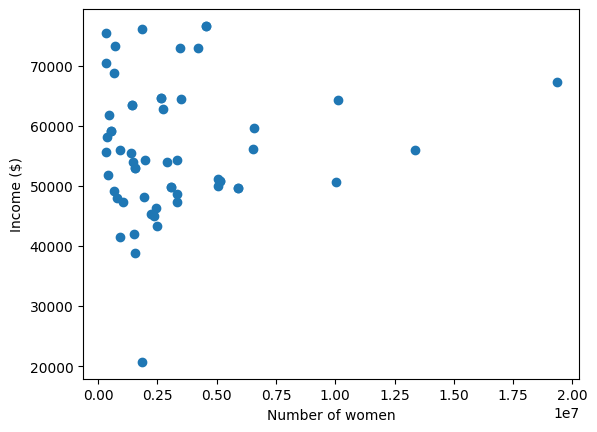

In [15]:
plt.scatter(us_census['Women'], us_census['Income'])
plt.xlabel('Number of women')
plt.ylabel('Income ($)')
plt.show()

9. You want to double check your work. You know from experience that these monstrous csv files probably have `nan` values in them! Print out your column with the number of women per state to see.

   We can fill in those `nan`s by using pandas' `.fillna()` function.
   
   You have the `TotalPop` per state, and you have the `Men` per state. As an estimate for the `nan` values in the `Women` column, you could use the `TotalPop` of that state minus the `Men` for that state.
   
   Print out the `Women` column after filling the `nan` values to see if it worked!

In [19]:
us_census['Women'] = us_census['Women'].fillna(us_census['TotalPop'] - us_census['Men'])
print(us_census['Women'])

0      543273.0
1     2455167.0
2      419713.0
3     3331859.0
4    13367298.0
5     1444150.0
0     1444150.0
1      318031.0
2     4195682.0
3     3497739.0
4      937789.0
5     2890732.0
0     3057895.0
1     3455936.0
2     5038598.0
3     2727005.0
4     1536358.0
5     3081445.0
0     3081445.0
1      504536.0
2      939759.0
3     1390901.0
4      670717.0
5     4561386.0
0     5913084.0
1     1942789.0
2     1990780.0
3     6534215.0
4     1869213.0
5      543273.0
0     4561386.0
1     1051703.0
2    10131373.0
3     5049925.0
4      353677.0
5     5913084.0
0     5123362.0
1      696428.0
2      806083.0
3     6556862.0
4     3333382.0
5     1558931.0
0     1558931.0
1     1453125.0
2     2233145.0
3     2364097.0
4      679019.0
5     3057895.0
0     2630239.0
1     1841615.0
2      478041.0
3      340810.0
4    10045763.0
5     5123362.0
0     2489527.0
1      349215.0
2     3342840.0
3     1506295.0
4    19334329.0
5     2630239.0
Name: Women, dtype: float64


10. We forgot to check for duplicates! Use `.duplicated()` on your `census` DataFrame to see if we have duplicate rows in there.

In [25]:
print(us_census)
duplicates = us_census.duplicated(subset=['State', 'TotalPop'])
print(duplicates.value_counts())

   Unnamed: 0                 State  TotalPop Hispanic   White   Black  \
0           0          Rhode Island   1053661   13.36%  74.33%   5.68%   
1           1        South Carolina   4777576    5.06%  62.89%  28.75%   
2           2          South Dakota    843190    3.24%  82.50%   1.42%   
3           3             Tennessee   6499615    4.72%  73.49%  18.28%   
4           4                 Texas  26538614   38.05%  44.69%  11.65%   
5           5                  Utah   2903379   13.47%  79.41%   1.02%   
0           0                  Utah   2903379   13.47%  79.41%   1.02%   
1           1               Vermont    626604    1.61%  93.98%   0.98%   
2           2              Virginia   8256630    8.01%  63.27%  20.18%   
3           3            Washington   6985464   11.14%  72.04%   3.38%   
4           4         West Virginia   1851420    1.29%  92.18%   3.66%   
5           5             Wisconsin   5742117    6.68%  79.86%   8.20%   
0           0              Maryland   

11. Drop those duplicates using the `.drop_duplicates()` function.

In [26]:
us_census = us_census.drop_duplicates(subset=['State', 'TotalPop'])
print(us_census)

   Unnamed: 0                 State  TotalPop Hispanic   White   Black  \
0           0          Rhode Island   1053661   13.36%  74.33%   5.68%   
1           1        South Carolina   4777576    5.06%  62.89%  28.75%   
2           2          South Dakota    843190    3.24%  82.50%   1.42%   
3           3             Tennessee   6499615    4.72%  73.49%  18.28%   
4           4                 Texas  26538614   38.05%  44.69%  11.65%   
5           5                  Utah   2903379   13.47%  79.41%   1.02%   
1           1               Vermont    626604    1.61%  93.98%   0.98%   
2           2              Virginia   8256630    8.01%  63.27%  20.18%   
3           3            Washington   6985464   11.14%  72.04%   3.38%   
4           4         West Virginia   1851420    1.29%  92.18%   3.66%   
5           5             Wisconsin   5742117    6.68%  79.86%   8.20%   
0           0              Maryland   5930538    8.47%  52.68%  30.68%   
1           1         Massachusetts   

12. Make the scatterplot again. Now, it should be perfect! Your job is secure, for now.

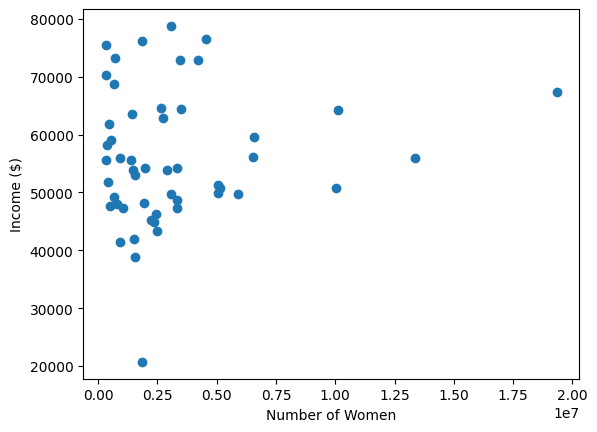

In [27]:
plt.scatter(us_census['Women'], us_census['Income'])
plt.xlabel('Number of Women')
plt.ylabel('Income ($)')
plt.show()

## Histogram of Races

13. Now your boss wants you to make a bunch of histograms out of the race data that you have. Look at the `.columns` again to see what the race categories are.

In [38]:
print(us_census.columns)
print(us_census.dtypes)
print(us_census.head())

Index(['Unnamed: 0', 'State', 'TotalPop', 'Hispanic', 'White', 'Black',
       'Native', 'Asian', 'Pacific', 'Income', 'GenderPop', 'Men', 'Women'],
      dtype='object')
Unnamed: 0      int64
State          object
TotalPop        int64
Hispanic      float64
White         float64
Black         float64
Native        float64
Asian         float64
Pacific       float64
Income        float64
GenderPop      object
Men             int64
Women         float64
dtype: object
   Unnamed: 0           State  TotalPop  Hispanic  White  Black  Native  \
0           0    Rhode Island   1053661     13.36  74.33   5.68    0.35   
1           1  South Carolina   4777576      5.06  62.89  28.75    0.29   
2           2    South Dakota    843190      3.24  82.50   1.42    9.42   
3           3       Tennessee   6499615      4.72  73.49  18.28    0.23   
4           4           Texas  26538614     38.05  44.69  11.65    0.26   

   Asian  Pacific    Income            GenderPop       Men       Women  
0   3

14. Try to make a histogram for each one!

    You will have to get the columns into the numerical format, and those percentage signs will have to go.
    
    Don't forget to fill the `nan` values with something that makes sense! You probably dropped the duplicate rows when making your last graph, but it couldn't hurt to check for duplicates again.

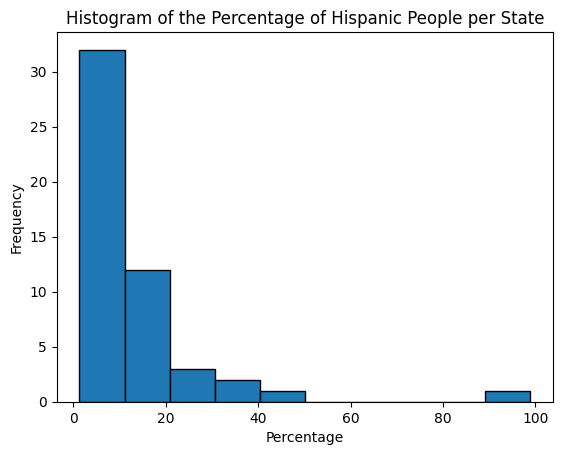

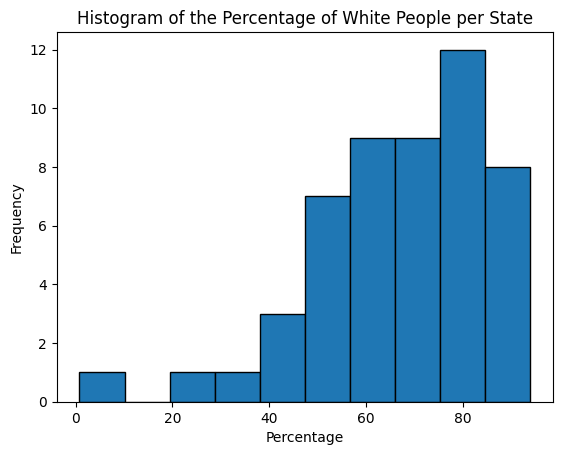

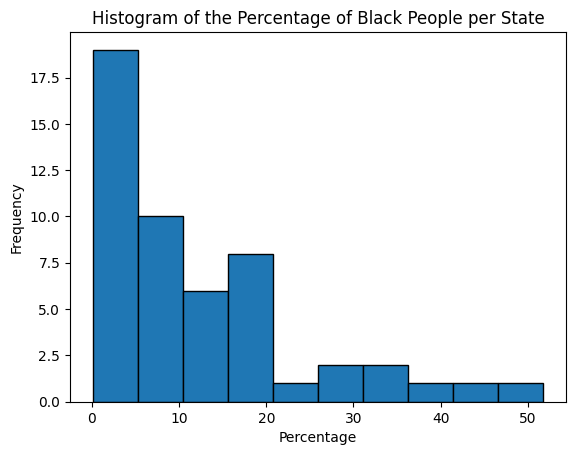

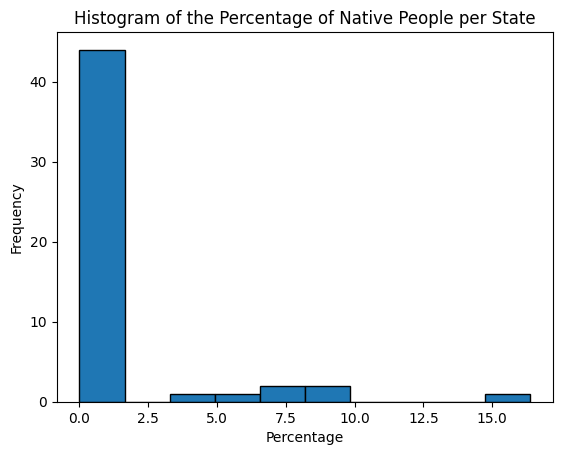

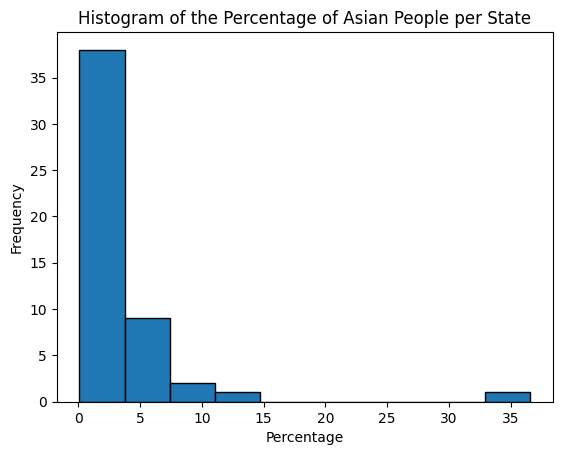

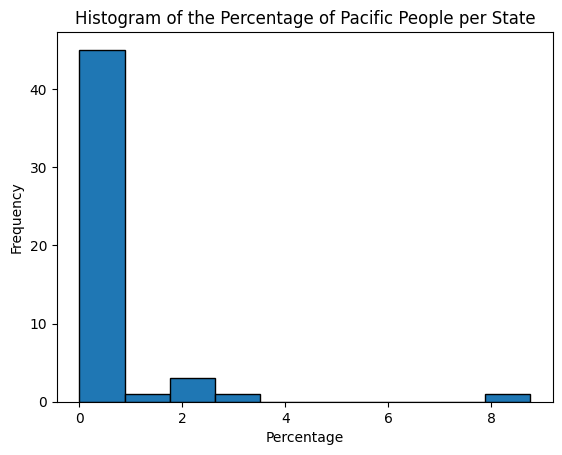

<Figure size 640x480 with 0 Axes>

In [45]:
# List of race columns
race_columns = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']

# Remove '%' and convert to numeric
# for column in race_columns:
#     us_census[column] = us_census[column].str.replace('%', '').astype(float)

# Fill missing 'Pacific' values
us_census['Pacific'] = us_census['Pacific'].fillna(100 - us_census['Hispanic'] - us_census['White'] - us_census['Black'] - us_census['Native'] - us_census['Asian'])

# Drop duplicates
census = us_census.drop_duplicates(subset=us_census.columns[1:])

# Plot histograms for each race
for race in race_columns:
    plt.hist(census[race], bins=10, edgecolor='black')
    plt.title(f"Histogram of the Percentage of {race} People per State")
    plt.xlabel("Percentage")
    plt.ylabel("Frequency")
    plt.show()
    plt.clf()

## Get Creative

15. Phew. You've definitely impressed your boss on your first day of work.

    But is there a way you really convey the power of pandas and Python over the drudgery of `csv` and Excel?
    
    Try to make some more interesting graphs to show your boss, and the world! You may need to clean the data even more to do it, or the cleaning you have already done may give you the ease of manipulation you've been searching for.

Unnamed: 0      int64
State          object
TotalPop        int64
Hispanic      float64
White         float64
Black         float64
Native        float64
Asian         float64
Pacific       float64
Income        float64
GenderPop      object
Men             int64
Women         float64
dtype: object


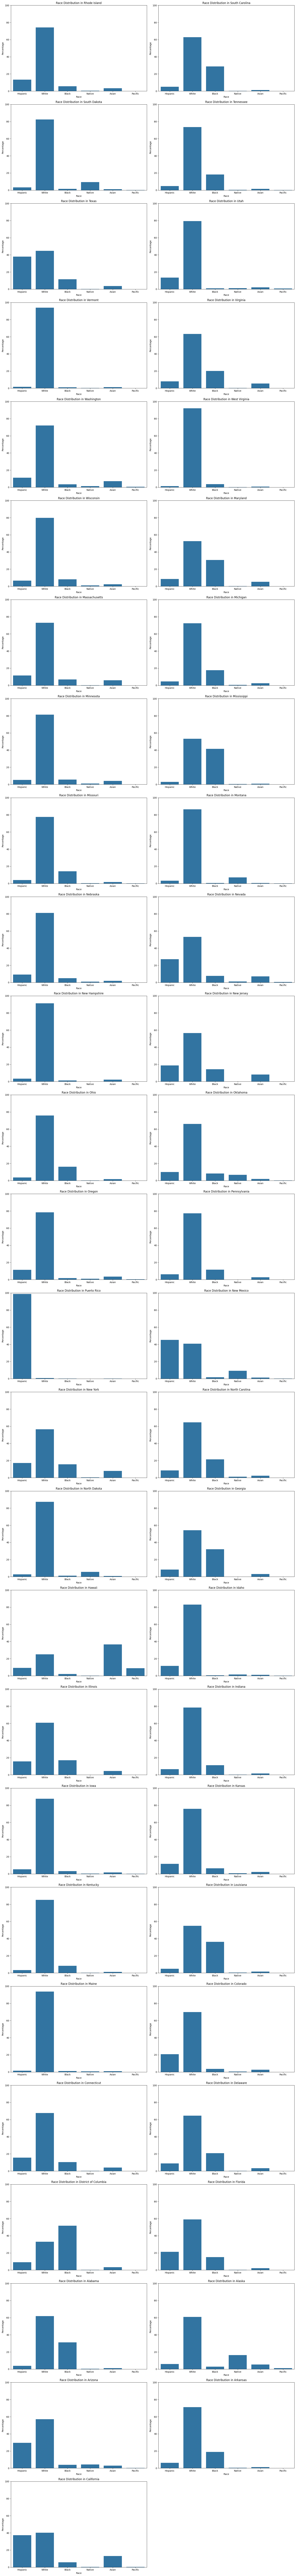

In [42]:
import seaborn as sns

# List of race columns
race_columns = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']

print(us_census.dtypes)

# Plot bar plots for each state in a 3-column layout
states = us_census['State'].unique()
num_states = len(states)
num_cols = 2
num_rows = (num_states + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 6))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, state in enumerate(states):
    state_data = us_census[us_census['State'] == state]
    state_data = state_data[race_columns].mean().reset_index()
    state_data.columns = ['Race', 'Percentage']
    
    sns.barplot(x='Race', y='Percentage', data=state_data, ax=axes[i])
    axes[i].set_title(f'Race Distribution in {state}')
    axes[i].set_xlabel('Race')
    axes[i].set_ylabel('Percentage')
    axes[i].set_ylim(0, 100)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()